In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('big_mart_train.csv')

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


___

There are quite a few missing values for item weight.  The solution will be to create a table grouped by item_identifier to reference for missing values. 

In [4]:
lookup_weight_values = data.iloc[:,0:2].groupby(by='Item_Identifier').max()

In [5]:
imputed_data = data

In [6]:
imputed_data = imputed_data.merge(lookup_weight_values,on='Item_Identifier')

In [7]:
imputed_data = imputed_data.drop(columns=['Item_Weight_x'])

In [8]:
imputed_data.rename(columns={'Item_Weight_y': 'Item_Weight'}, inplace=True)

---
### Outlet Size Results

I chose these manually because of the low number of cases to model.  There is a better method I'm sure, but this is quick and should be close enough for the time being. 

* Outlet 10 Medium....only 1 other grocery store.  Both are similar and the other is Medium.
* Outlet 17 small...less sales than OUTO35(small)
* Outlet 45 small...lowest sales for Tier 2 Supermarket Type1

In [9]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT010", 
         "Medium", imputed_data['Outlet_Size'])

In [10]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT017", 
         "Small", imputed_data['Outlet_Size'])

In [11]:
imputed_data['Outlet_Size'] = np.where(imputed_data['Outlet_Identifier'] == "OUT045", 
         "Small", imputed_data['Outlet_Size'])

---
* Drop cases with missing weights...should be 4

In [12]:
# drop rows with missing values (only 4 in this case)
imputed_data = imputed_data.dropna()

___

* Drop Variables
   1. Item Fat Content
   2. Item Type
   3. Outlet Identifier
* Encode dummy variables
* Split lable from data

In [13]:
data_encoded = imputed_data

In [14]:
#item identifier isn't useful in this context
data_encoded = data_encoded.drop(['Item_Identifier', 'Item_Type', 'Item_Fat_Content', 'Outlet_Identifier'], axis='columns')

In [15]:
#encode non_numeric types to their own column with binary values
data_encoded = pd.get_dummies(data_encoded)

In [16]:
data_label = data_encoded.pop('Item_Outlet_Sales')

In [17]:
#add the label to the end of the DF
data_encoded['Item_Outlet_Sales'] = data_label

___

### Prepare to model

* Create x & y 
* Split data into train / test

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X, y = data_encoded.iloc[:,:-1],data_encoded.iloc[:,-1]

In [20]:
seed = 7
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

___

### XGBoost

In [21]:
import xgboost as xgb

In [22]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [23]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [24]:
xgb_model = xg_reg.fit(x_train,y_train)
y_xgb = xgb_model.predict(x_test)

---

### Evaluate Model

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import sqrt

___

XGBoost

In [26]:
r2_score(y_test, y_xgb)

0.596012479230885

In [27]:
sqrt(mean_squared_error(y_test, y_xgb))

1073.8260961997253

With all 48 features, accuracy was 1074.68....slightly better with a simple model. Outlet_Identifier will likely be important internal to the business where geographic information could be added.

---
### Feature Importance

In [28]:
from xgboost import plot_importance

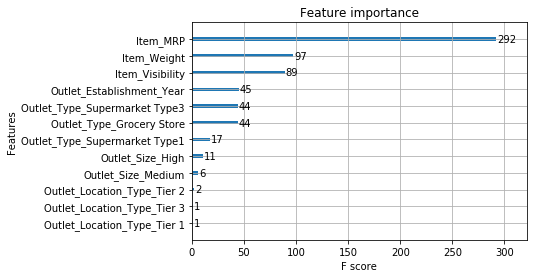

In [29]:
plot_importance(xgb_model)

___
Plot Results

In [30]:
import matplotlib.pyplot as plt

### Actual vs Predicted

XGB vs Actual 

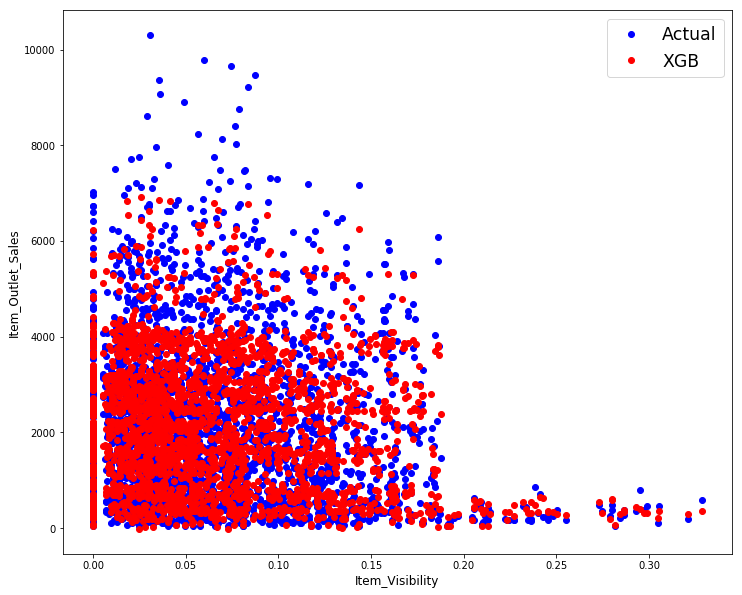

In [31]:
plt.figure(figsize=(12,10))
plt.plot(x_test['Item_Visibility'], y_test, 'o', color='b', label='Actual')
plt.plot(x_test['Item_Visibility'], y_xgb, 'o', color='r', label='XGB')
plt.xlabel("Item_Visibility", fontsize='large')
plt.ylabel("Item_Outlet_Sales", fontsize='large')
plt.legend(fontsize='xx-large')

---


## Import Test Data

In [99]:
test_data = pd.read_csv('test-file.csv')

In [100]:
test_data.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

### #FIXME

Prior to submitting for competition, missing data will need to be imputed.  For the current project, missing data will be dropped for simplicity

In [101]:
#same outlets that were missing size before
test_data[test_data['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
8,FDN33,6.305,Regular,0.123365,Snack Foods,95.7436,OUT045,2002,NaN,Tier 2,Supermarket Type1
9,FDA36,5.985,Low Fat,0.005698,Baking Goods,186.8924,OUT017,2007,NaN,Tier 2,Supermarket Type1
10,FDT44,16.600,Low Fat,0.103569,Fruits and Vegetables,118.3466,OUT017,2007,NaN,Tier 2,Supermarket Type1
11,FDQ56,6.590,Low Fat,0.105811,Fruits and Vegetables,85.3908,OUT045,2002,NaN,Tier 2,Supermarket Type1
16,FDI57,19.850,Low Fat,0.054135,Seafood,198.7768,OUT045,2002,NaN,Tier 2,Supermarket Type1
19,FDA46,13.600,Low Fat,0.196898,Snack Foods,193.7136,OUT010,1998,NaN,Tier 3,Grocery Store
25,FDX22,6.785,Regular,0.038455,Snack Foods,209.4928,OUT010,1998,NaN,Tier 3,Grocery Store


In [102]:
test_data['Outlet_Size'] = np.where(test_data['Outlet_Identifier'] == "OUT010", 
         "Medium", test_data['Outlet_Size'])

In [103]:
test_data['Outlet_Size'] = np.where(test_data['Outlet_Identifier'] == "OUT017", 
         "Small", test_data['Outlet_Size'])

In [104]:
test_data['Outlet_Size'] = np.where(test_data['Outlet_Identifier'] == "OUT045", 
         "Small", test_data['Outlet_Size'])

In [105]:
test_data.isnull().sum()

Item_Identifier                0
Item_Weight                  976
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
dtype: int64

---
### Impute Weights

In [106]:
test_data = test_data.merge(lookup_weight_values,on='Item_Identifier')

In [107]:
test_data = test_data.drop(columns=['Item_Weight_x'])

In [108]:
test_data.rename(columns={'Item_Weight_y': 'Item_Weight'}, inplace=True)

In [109]:
test_data.isnull().sum()

Item_Identifier               0
Item_Fat_Content              0
Item_Visibility               0
Item_Type                     0
Item_MRP                      0
Outlet_Identifier             0
Outlet_Establishment_Year     0
Outlet_Size                   0
Outlet_Location_Type          0
Outlet_Type                   0
Item_Weight                  31
dtype: int64

In [65]:
#drop 31 missing weight cases for now
test_data = test_data.dropna()

---
### Prepare columns to match model

In [110]:
orig_test = test_data

In [111]:
test_data = test_data.drop(['Item_Identifier', 'Item_Type', 'Item_Fat_Content', 'Outlet_Identifier'], axis='columns')

In [112]:
test_data.columns

Index(['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Weight'],
      dtype='object')

In [113]:
test_data = pd.get_dummies(test_data)

In [114]:
y_test_data = xgb_model.predict(test_data)

In [115]:
predicted_data = orig_test

In [116]:
predicted_data['Outlet_Sales'] = y_test_data

In [117]:
predicted_data.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Weight,Outlet_Sales
0,FDW58,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,20.75,1492.636841
1,FDW58,Low Fat,0.007596,Snack Foods,104.4622,OUT017,2007,Small,Tier 2,Supermarket Type1,20.75,1494.185669
2,FDW58,Low Fat,0.007584,Snack Foods,107.0622,OUT018,2009,Medium,Tier 3,Supermarket Type2,20.75,1431.848267
3,FDW58,Low Fat,0.000000,Snack Foods,105.9622,OUT046,1997,Small,Tier 1,Supermarket Type1,20.75,1442.967773
4,FDW58,Low Fat,0.007568,Snack Foods,105.8622,OUT045,2002,Small,Tier 2,Supermarket Type1,20.75,1421.925293


---

### Prepare Data In Presentation Form

* Item Identifer
* Oulet Identifer
* Outlet Sales

In [118]:
presentation_data = pd.DataFrame()

In [119]:
presentation_data['Item_Identifier'] = predicted_data['Item_Identifier']

In [120]:
presentation_data['Outlet_Identifier'] = predicted_data['Outlet_Identifier']

In [121]:
presentation_data['Item_Outlet_Sales'] = predicted_data['Outlet_Sales']

In [122]:
presentation_data.to_csv('submission.csv', index=False)

---
### Results

First pass scored 1151

![title](img/results.png)